# Setup

# Imports

In [11]:
import os
import sys
import string
import csv
import datetime
from pprint import pprint
from matplotlib.pyplot import *
from numpy import *

import mpl_toolkits.mplot3d.axes3d as p3

from scipy.optimize import fmin_bfgs as unbounded_bfgs
from scipy.optimize import fmin as simplex
from scipy.optimize import fmin_l_bfgs_b as bounded_bfgs

import pandas as pd

# Some data for fitting

In [6]:
vola_data = pd.read_csv("QuotedSurface.csv")
allVols = vola_data.values

marketSkew = allVols[  allVols[:,2]=='12/19/2009'   ]
calls = marketSkew[marketSkew[:,1]=='Call',]
puts = marketSkew[marketSkew[:,1]=='Put',]
callOffers = calls[   calls[:,4]>0   ][:,(0,4)]
callBids = calls[  calls[:,3]>0   ][:,(0,3)]
putOffers = puts[puts[:,4]>0][:,(0,4)]
putBids = puts[puts[:,3]>0][:,(0,3)]
print(putOffers)

[[10.0 141.8956]
 [12.5 103.2488]
 [15.0 84.05043]
 [17.5 72.2881]
 [20.0 63.5784]
 [22.5 62.58511]
 [25.0 66.60337]
 [30.0 86.1619]
 [35.0 111.2435]]


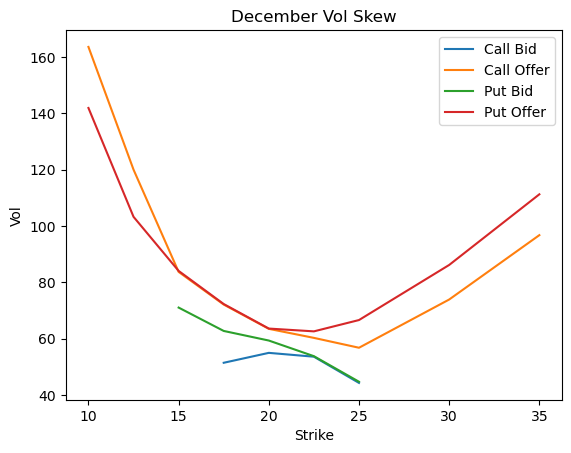

In [9]:
plot(callBids[:,0], callBids[:,1],label='Call Bid')
plot(callOffers[:,0], callOffers[:,1],label='Call Offer')
plot(putBids[:,0], putBids[:,1], label='Put Bid')
plot(putOffers[:,0], putOffers[:,1], label='Put Offer')
xlabel('Strike')
ylabel('Vol')
legend()
ptitle = title('December Vol Skew')


# Fitting

## Choose something to fit

### Single maturity skew, put offers

In [12]:
inputSeries = putOffers
strikes = inputSeries[:,0]
vols = inputSeries[:,1]
weights = ones_like( strikes )

### Target function -- minimize sum of squared differences in volatility  $$ F(x) = \sum_{i=1}^N w_i \left( x_0 + x_1 K_i + x_2 K_i^2 -  \sigma(K_i) \right)^2 $$  $$ x_{\text{opt}} = \arg \min_x(F(x)) $$

In [13]:
global numFcnCalls, strikes, weights, vols
numFcnCalls = 0   # Track how computationally expensive things have been
def quadratic(x,a,b,c):
    return a+b*x+c*x**2
def volDiffSq( x ):
    global numFcnCalls, strikes, weights, vols
    numFcnCalls += 1
    a = x[0]
    try: # Allow linear and quadratic terms to be missing
        b = x[1]
        try:
            c = x[2]
        except Exception:
            c = 0
    except Exception:
        b=0
        c=0
    q = quadratic(strikes, a,b,c)
    errs= vols - q
    sm = sum(weights*errs**2)
    return sm

#### Check what its output looks like

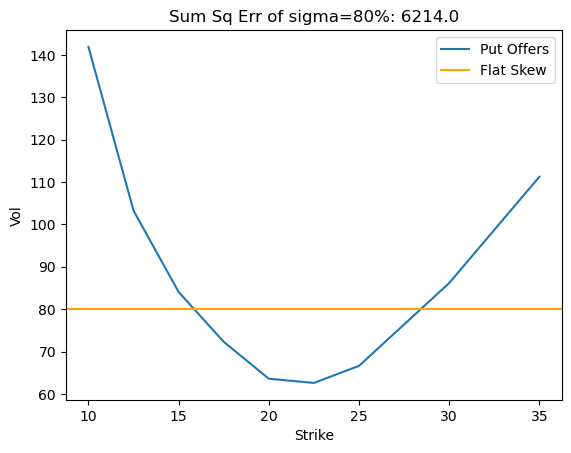

In [14]:
plot(strikes,vols,label='Put Offers')
axhline(80,color='orange',label='Flat Skew')
xlabel('Strike')
ylabel('Vol')
legend()
flatSSE = volDiffSq([80,0,0])
titleString = 'Sum Sq Err of sigma=80%: {sse:.1f}'.format(sse=flatSSE)
ptitle = title(titleString)

## What flat skew fits best?

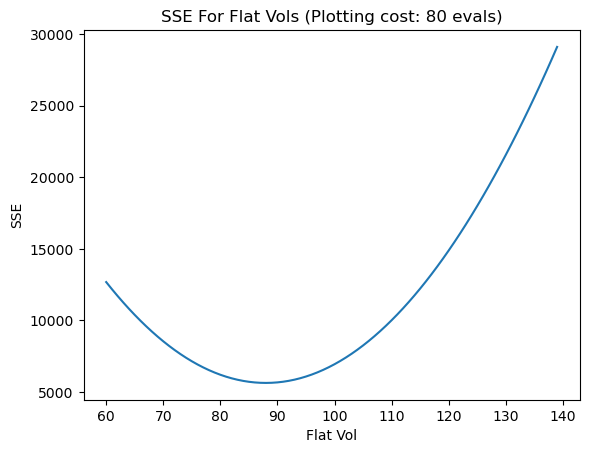

In [15]:
numFcnCalls = 0
flatVolsInGrid = arange(60,140)
flatSkews = zeros((flatVolsInGrid.shape[0],3))
flatSkews[:,0]= flatVolsInGrid
flatSSEs = [volDiffSq( flatVol ) for flatVol in flatSkews]
plot(flatVolsInGrid, flatSSEs)
xlabel('Flat Vol')
ylabel('SSE')
ptitle = title('SSE For Flat Vols (Plotting cost: {nf:d} evals)'.format(nf=numFcnCalls))

### The eye thinks somewhere just under 90%.  What does a fitting algorithm think?

In [16]:
numFcnCalls = 0
xopt = unbounded_bfgs(volDiffSq,[80,])[0]
print('The optimal flat skew by SSE is {x:.2f}'.format(x=xopt))
print('  (found at a cost of {nf:d} function evaluations)'.format(nf=numFcnCalls))

Optimization terminated successfully.
         Current function value: 5643.497156
         Iterations: 4
         Function evaluations: 16
         Gradient evaluations: 8
The optimal flat skew by SSE is 87.96
  (found at a cost of 16 function evaluations)


## How about linear skew?

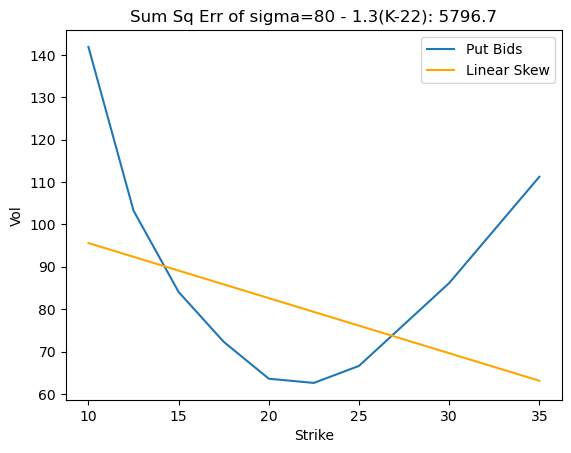

In [18]:
plot(strikes,vols,label='Put Bids')
linearSkew = 80 + (-1.3) * (strikes-22)
plot(strikes,linearSkew,color='orange',label='Linear Skew')
xlabel('Strike')
ylabel('Vol')
legend()
linearSSE = volDiffSq([80+1.3*22,-1.3,0])
titleString = 'Sum Sq Err of sigma=80 - 1.3(K-22): {sse:.1f}'.format(sse=linearSSE)
ptitle = title(titleString)


### Our potential choices are now a 2-d surface

In [27]:
numFcnCalls = 0
x0s = arange(60,220,2)#(60,140)
x1s = arange(-3,1.0,0.1)#(-5,0,0.1)
X, Y = meshgrid(x0s,x1s)
XY = array([X,Y]).T
Z = array([[ volDiffSq([a,b]) for b in x1s] for a in x0s]).T


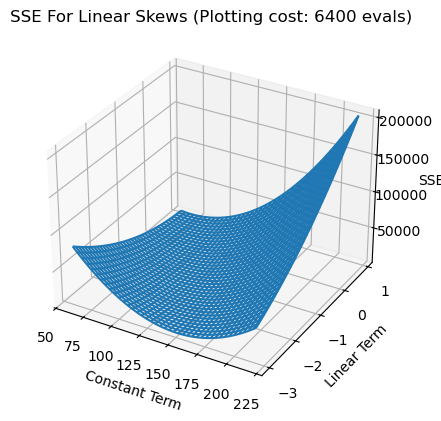

In [28]:
Z = array([[volDiffSq([a,b]) for b in x1s] for a in x0s]).T

fig = figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, Y, Z)
ax.set_xlabel('Constant Term')
ax.set_ylabel('Linear Term')
ax.set_zlabel('SSE')
title(f'SSE For Linear Skews (Plotting cost: {numFcnCalls:d} evals)')
show()


### It's hard for the eye to find a minimum.  What does a solver think?

In [29]:
numFcnCalls = 0
xopt_linear = unbounded_bfgs(volDiffSq,[80+1.3*22,-1.3])
print('The optimal linear skew by SSE is {x0:.1f} + ({x1:.3f})*K'.format(x0=xopt_linear[0],x1=xopt_linear[1]))
print('  (found at a cost of {nf:d} function evaluations)'.format(nf=numFcnCalls))

         Current function value: 5292.653937
         Iterations: 3
         Function evaluations: 24
         Gradient evaluations: 8
The optimal linear skew by SSE is 104.8 + (-0.808)*K
  (found at a cost of 24 function evaluations)


/Users/brian/5assets/lib/python3.13/site-packages/scipy/optimize/_optimize.py:1330: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


Text(0.5, 0, 'SSE')

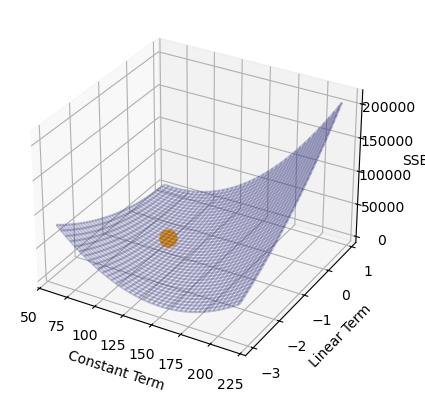

In [30]:
x0s = arange(60, 220, 2)
x1s = arange(-3, 1.0, 0.1)
X, Y = meshgrid(x0s, x1s)

Z = array([[volDiffSq([a, b]) for b in x1s] for a in x0s]).T  # Shape: (len(x1s), len(x0s))

fig = figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(X, Y, Z, color=(0.2, 0.2, 0.5, 0.3))

# Scatter optimal point
ax.scatter(
    xopt_linear[0],          # single value, not a slice
    xopt_linear[1],          # single value, not a slice
    volDiffSq(xopt_linear),  # function value at optimum
    color='orange', s=150
)

ax.set_xlabel('Constant Term')
ax.set_ylabel('Linear Term')
ax.set_zlabel('SSE')


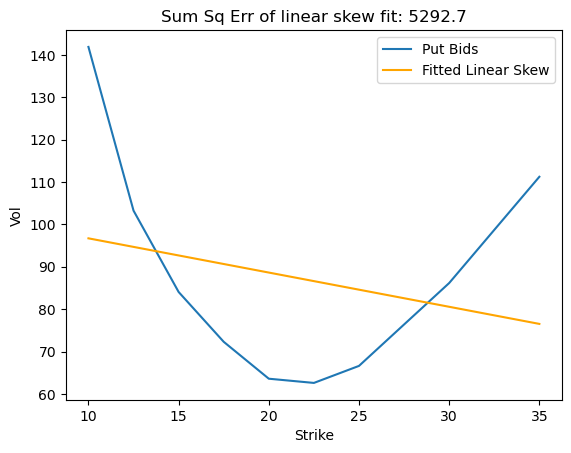

In [31]:
plot(strikes,vols,label='Put Bids')
linearSkew = xopt_linear[0] + xopt_linear[1] * (strikes)
plot(strikes,linearSkew,color='orange',label='Fitted Linear Skew')
xlabel('Strike')
ylabel('Vol')
legend()
linearSSE = volDiffSq(xopt_linear)
titleString = 'Sum Sq Err of linear skew fit: {sse:.1f}'.format(sse=linearSSE)
ptitle = title(titleString)


## For quadratic skew, visualization is difficult.  But we can still solve.

In [32]:
numFcnCalls = 0
xopt_quadratic = unbounded_bfgs(volDiffSq,[100,-1.3,0.1])
print('The optimal quadratic skew by SSE is {x0:.1f} + ({x1:.2f})*K + ({x2:.3g})*K^2'.format(
            x0=xopt_quadratic[0],x1=xopt_quadratic[1],x2=xopt_quadratic[2]))
print('  (found at a cost of {nf:d} function evaluations)'.format(nf=numFcnCalls))

Optimization terminated successfully.
         Current function value: 238.964695
         Iterations: 5
         Function evaluations: 40
         Gradient evaluations: 10
The optimal quadratic skew by SSE is 282.1 + (-18.94)*K + (0.406)*K^2
  (found at a cost of 40 function evaluations)


### How does the fit look?

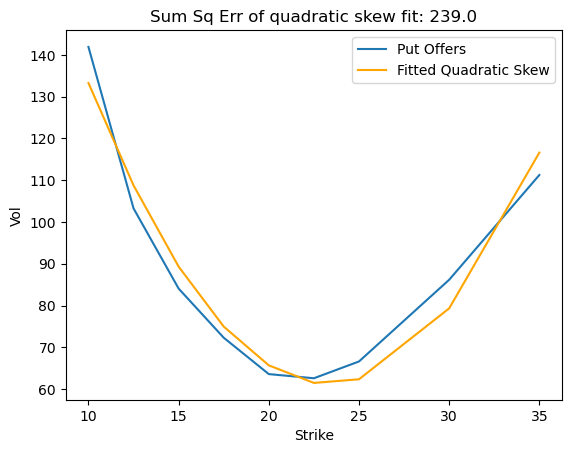

In [33]:
plot(strikes,vols,label='Put Offers')
linearSkew = xopt_quadratic[0] + xopt_quadratic[1] * (strikes) + xopt_quadratic[2] * (strikes**2)
plot(strikes,linearSkew,color='orange',label='Fitted Quadratic Skew')
xlabel('Strike')
ylabel('Vol')
legend()
quadraticSSE = volDiffSq(xopt_quadratic)
titleString = 'Sum Sq Err of quadratic skew fit: {sse:.1f}'.format(sse=quadraticSSE)
ptitle = title(titleString)


## What if we were to fit to all available vols?

In [41]:
strikes = np.concatenate( (putBids[:,0], putOffers[:,0], callBids[:,0], callOffers[:,0]))
vols = np.concatenate( (putBids[:,1], putOffers[:,1], callBids[:,1], callOffers[:,1]))

### Out-of-the-money options are considered the most reliable market indicators

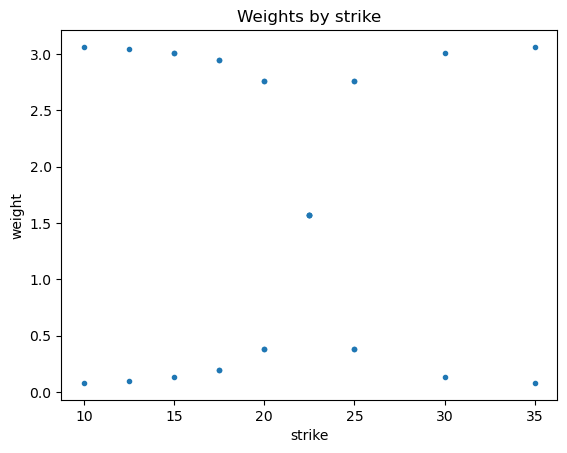

In [44]:
strikes = np.concatenate((putBids[:,0], putOffers[:,0], callBids[:,0], callOffers[:,0]))
vols    = np.concatenate((putBids[:,1], putOffers[:,1], callBids[:,1], callOffers[:,1]))

# Compute distances (all are vectors!)
distances = np.array(np.concatenate((
    -(putBids[:,0] - 22.5),
    -(putOffers[:,0] - 22.5),
    callBids[:,0] - 22.5,
    callOffers[:,0] - 22.5)
), dtype=float)
weights = np.pi/2 + np.arctan(distances)   # safe: np.arctan & np.pi

plot(strikes, weights, '.')
xlabel('strike')
ylabel('weight')
title('Weights by strike')
show()


In [45]:
numFcnCalls = 0
xopt_quadratic_all = unbounded_bfgs(volDiffSq,[100,-1.3,0.1])
print('The optimal quadratic skew by SSE is {x0:.1f} + ({x1:.2f})*K + ({x2:.3g})*K^2'.format(
            x0=xopt_quadratic_all[0],x1=xopt_quadratic_all[1],x2=xopt_quadratic_all[2]))
print('  (found at a cost of {nf:d} function evaluations)'.format(nf=numFcnCalls))
fitted_vols_all = xopt_quadratic_all[0]+strikes*xopt_quadratic_all[1]+strikes**2*xopt_quadratic_all[2]

         Current function value: 2160.468806
         Iterations: 6
         Function evaluations: 204
         Gradient evaluations: 48
The optimal quadratic skew by SSE is 287.5 + (-19.62)*K + (0.409)*K^2
  (found at a cost of 204 function evaluations)


/Users/brian/5assets/lib/python3.13/site-packages/scipy/optimize/_optimize.py:1330: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)


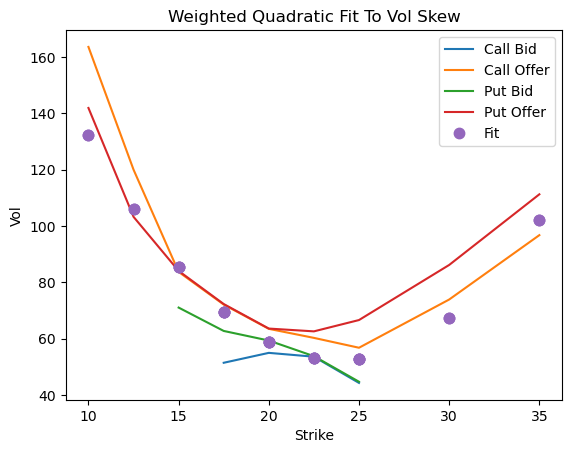

In [47]:
plot(callBids[:,0], callBids[:,1],label='Call Bid')
plot(callOffers[:,0], callOffers[:,1],label='Call Offer')
plot(putBids[:,0], putBids[:,1], label='Put Bid')
plot(putOffers[:,0], putOffers[:,1], label='Put Offer')
plot(strikes, fitted_vols_all, '.', markersize=15, label='Fit')
xlabel('Strike')
ylabel('Vol')
legend()
ptitle = title('Weighted Quadratic Fit To Vol Skew')


# The Volatility Surface

# What might we do with entire term structure of volatilies?

### We need a functional parameterization of volatility by expiration and strike

#### Simple form, using forward prices $F(t) = S_0 e^{(r-q)t}$

$$
\sigma(K, t) = \sigma_0 + \sigma_1 (K-F(t)) + \sigma_2 (K-F(t))^2
$$

#### A better form notes that a "typical" move in underlying price is proportional to $\sigma\sqrt{T}$.  We normalize strike distances by this moneyness parameter.

$$
\sigma(K, t) = \sigma_0     + \sigma_1 \frac{K-F(t)}{\sqrt{T}}
                + \sigma_2 \left(\frac{K-F(t)}{\sqrt{T}}\right)^2
$$

#### A common approach is to define skews in terms of at-the-money volatility $\sigma_{\text{ATM}}(t)$ for any given tenor.  Note that in this case we have a 2-step fitting procedure...one to get $\sigma_{\text{ATM}}(t)$ and the next to fit the remainder of the curve.

$$
\sigma(K, t) = \sigma_{\text{ATM}}(t) \left(\mu_0    + \mu_1 \frac{K-F(t)}{\sqrt{T}}
                + \mu_2 \left(\frac{K-F(t)}{\sqrt{T}}\right)^2 \right)
$$

#### Tick limits and other effects often cause us to want to limit fitted vols.  It's important that our fit function and its inputs be subjected to the same limits when we are fitting.

$$
\sigma(K, t) = \max\left(\sigma_{\text{min}},\min\left(\sigma_{\text{max}},\sigma_{\text{ATM}}(t) \left(\mu_0    + \mu_1 \frac{K-F(t)}{\sqrt{T}}
                + \mu_2 \left(\frac{K-F(t)}{\sqrt{T}}\right)^2 \right) \right) \right)
$$

#### Expressing in return space, rather than absolute terms, is very common

$$
\sigma(K, t) = \max\left(\sigma_{\text{min}},\min\left(\sigma_{\text{max}},\sigma_{\text{ATM}}(t) \left(\mu_0    + \mu_1 \frac{\log(K/F(t))}{\sqrt{T}}
+ \mu_2 \left(\frac{\log(K/F(t))}{\sqrt{T}}\right)^2 \right) \right) \right)
$$

#### Sometimes rather than rough cutoffs, we use limited response functions, like $\tanh(\cdot)$

$$
tanh(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}
$$

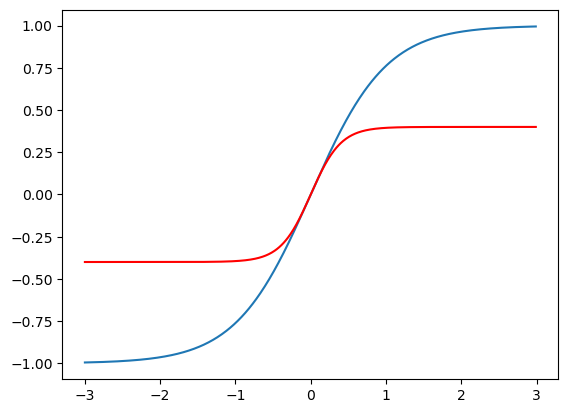

In [48]:
xr=arange(-3,3,0.01)
plot(xr,tanh(xr))
plot(xr, .4 *tanh(xr/.4),'r')

### Tractability of our surface function is a desirable feature.  It is convenient if we can obtain the skew-implied risk neutral terminal distribution of underlying prices.

$$
C(K,T)=e^{-rT} \int_0^\infty \left(S_T-K\right)^+ p(S_T) dS_T 
$$
$$
C(K,T)=e^{-rT} \int_K^\infty \left(S_T-K\right) p(S_T) dS_T 
$$
$$
\frac{d}{dK}C(K,T)=e^{-rT} \int_K^\infty \left( -1 \right) p(S_T) dS_T
$$
$$
\frac{d^2}{dK^2}C(K,T)=e^{-rT} (-1)\left(p(\infty) - p(K)\right)
$$
$$
\frac{d^2}{dK^2}C(K,T)= e^{-rT}  p(K)
$$
$$
p(K) = e^{rT}  \frac{d^2}{dK^2}C(K,T)  
$$

#### Density for flat skew

$$
p(S,t) = e^{-rt}  \frac{1}{S\sigma\sqrt{t}} \cdot n\left( \frac{\log(S_0/S)+(r-q)t-\frac12 \sigma\sqrt{t}}{\sigma\sqrt{t}}  \right)
$$